In [1]:
!pip install torchinfo

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
data_dir = "/kaggle/input/Fish Data raw/Fish Data"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Rui, Count: 2500
Class: Taki, Count: 2223
Class: Telapiya, Count: 2058
Class: Mrigel, Count: 1808
Class: Aair, Count: 1804
Class: Katla, Count: 1765
Class: Pabda, Count: 1764
Class: Boal, Count: 1651
Class: Puti, Count: 1560
Class: Tengra, Count: 1431
Class: Shol, Count: 1424
Class: Tarabaim, Count: 1262
Class: Ilish, Count: 1031
Class: Pangas, Count: 934
Class: KalBaush, Count: 917
Class: Koi, Count: 842
Class: Magur, Count: 574
Class: Foli, Count: 562
Class: Chapila, Count: 428
Class: DeshiPuti, Count: 412


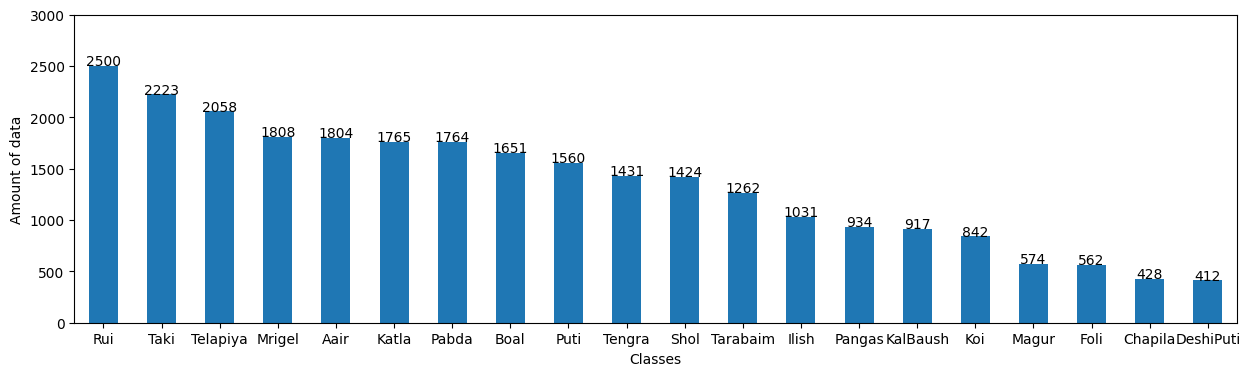

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(15, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

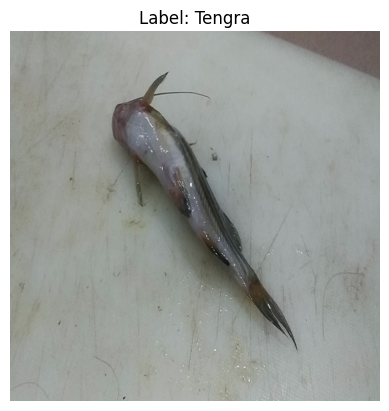

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18865
Validation Data:  4042
Test Data:  4043
-------------------------------------------
Total amounts of data in the dataset:  26950


In [10]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class        Count
---------  -------
Rui           1750
Taki          1556
Telapiya      1441
Mrigel        1265
Aair          1263
Pabda         1235
Katla         1235
Boal          1156
Puti          1092
Tengra        1002
Shol           997
Tarabaim       883
Ilish          722
Pangas         654
KalBaush       642
Koi            589
Magur          402
Foli           393
Chapila        300
DeshiPuti      288

Validation Dataset
Class        Count
---------  -------
Rui            375
Taki           333
Telapiya       308
Mrigel         271
Aair           270
Katla          265
Pabda          264
Boal           247
Puti           234
Shol           214
Tengra         214
Tarabaim       190
Ilish          155
Pangas         140
KalBaush       138
Koi            127
Magur           86
Foli            85
Chapila         64
DeshiPuti       62

Test Dataset
Class        Count
---------  -------
Rui            375
Taki           334
Telapiya       309
Mrigel         272
Aa

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())  # Ensure consistent order
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [ ]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

In [ ]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [ ]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

In [16]:
import torch.nn as nn

class FishNet(nn.Module):
    def __init__(self, num_classes):
        super(FishNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),     # (B, 32, 224, 224)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 # (B, 32, 112, 112)

            nn.Conv2d(32, 64, 3, padding=1),    # (B, 64, 112, 112)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 # (B, 64, 56, 56)

            nn.Conv2d(64, 128, 3, padding=1),   # (B, 128, 56, 56)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 # (B, 128, 28, 28)

            nn.Conv2d(128, 256, 3, padding=1),  # (B, 256, 28, 28)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 # (B, 256, 14, 14)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                       # (B, 256*14*14 = 50176)
            nn.Linear(256 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [17]:
model = FishNet(num_classes=20).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
import time
import torch
from tqdm.notebook import tqdm
import pandas as pd
import os

start_time = time.time()
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_val_acc = 0.0

    # Make sure checkpoint directory exists
    os.makedirs(save_path_checkpoints, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        # Save checkpoint if improved
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save({
                'epoch': epoch,
                'model_weight': model.state_dict(),
                'optimizer_state': optimizer.state_dict()
            }, f"{save_path_checkpoints}/model.pt")

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    elapsed = time.time() - start_time
    print(f"\nTraining complete in {elapsed//60:.0f}m {elapsed%60:.0f}s")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Run training
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer,
    dataloader_train_dataset, dataloader_valid_dataset,
    num_epochs=20,
    save_path_checkpoints="checkpoints"
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

# Save training history
data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.8255 | Train Acc: 0.4157 | Val Loss: 0.8481 | Val Acc: 0.7390


Epoch 2/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.8343 | Train Acc: 0.7298 | Val Loss: 0.4236 | Val Acc: 0.8639


Epoch 3/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.5325 | Train Acc: 0.8270 | Val Loss: 0.2536 | Val Acc: 0.9191


Epoch 4/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.3795 | Train Acc: 0.8775 | Val Loss: 0.2608 | Val Acc: 0.9164


Epoch 5/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.2903 | Train Acc: 0.9063 | Val Loss: 0.1607 | Val Acc: 0.9476


Epoch 6/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.2499 | Train Acc: 0.9185 | Val Loss: 0.1219 | Val Acc: 0.9602


Epoch 7/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.1963 | Train Acc: 0.9368 | Val Loss: 0.1332 | Val Acc: 0.9552


Epoch 8/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.1800 | Train Acc: 0.9410 | Val Loss: 0.1259 | Val Acc: 0.9574


Epoch 9/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.1519 | Train Acc: 0.9503 | Val Loss: 0.0796 | Val Acc: 0.9733


Epoch 10/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.1344 | Train Acc: 0.9553 | Val Loss: 0.0980 | Val Acc: 0.9681


Epoch 11/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.1289 | Train Acc: 0.9577 | Val Loss: 0.0962 | Val Acc: 0.9711


Epoch 12/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.1116 | Train Acc: 0.9632 | Val Loss: 0.1125 | Val Acc: 0.9631


Epoch 13/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.1015 | Train Acc: 0.9667 | Val Loss: 0.0655 | Val Acc: 0.9787


Epoch 14/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0971 | Train Acc: 0.9683 | Val Loss: 0.0800 | Val Acc: 0.9715


Epoch 15/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0935 | Train Acc: 0.9697 | Val Loss: 0.0740 | Val Acc: 0.9767


Epoch 16/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0872 | Train Acc: 0.9704 | Val Loss: 0.0754 | Val Acc: 0.9800


Epoch 17/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0809 | Train Acc: 0.9732 | Val Loss: 0.1007 | Val Acc: 0.9693


Epoch 18/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0783 | Train Acc: 0.9747 | Val Loss: 0.1434 | Val Acc: 0.9594


Epoch 19/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0809 | Train Acc: 0.9747 | Val Loss: 0.0832 | Val Acc: 0.9760


Epoch 20/20 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0702 | Train Acc: 0.9773 | Val Loss: 0.0608 | Val Acc: 0.9817

Training complete in 37m 57s
Best Validation Accuracy: 0.9817
Training Time: 2277.03 seconds ---> 37.95 minutes


# Load the Best Trained Model

In [19]:
# --- HYBRID MODEL PART 1: Load Best CNN ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataframe['label'].unique())  # Should be 9
model = FishNet(num_classes=num_classes).to(device)

# Load the best checkpoint
checkpoint_path = "checkpoints/model.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_weight'])
model.eval()  # Important: set to evaluation mode

print("Best CNN model loaded for feature extraction.")

Best CNN model loaded for feature extraction.


# Add Feature Extraction Wrapper

In [20]:
# --- HYBRID MODEL PART 2: Feature Extractor ---
import torch.nn as nn
from tqdm.notebook import tqdm
import numpy as np

# Create a sub-model that stops at 256-D features (before final classifier layers)
class FishNetFeatures(nn.Module):
    def __init__(self, original_model):
        super(FishNetFeatures, self).__init__()
        self.features = original_model.features
        # Take only up to the 256-D representation (before last 3 layers: dropout, linear, output)
        self.classifier_part = nn.Sequential(*list(original_model.classifier.children())[:-3])  # Up to 256-D

    def forward(self, x):
        x = self.features(x)
        x = self.classifier_part(x)
        return x

# Wrap your trained model
feature_extractor = FishNetFeatures(model).to(device)
feature_extractor.eval()
print(" Feature extractor ready: outputs 256-D features.")

 Feature extractor ready: outputs 256-D features.


# Extract Features from Train and Test Sets

In [21]:
# --- HYBRID MODEL PART 3: Extract Features ---
def extract_features(extractor, data_loader, device):
    extractor.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            feats = extractor(images)  # Shape: [batch, 256]
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
    return np.concatenate(features_list, axis=0), np.concatenate(labels_list, axis=0)

# Run extraction
X_train_feats, y_train = extract_features(feature_extractor, dataloader_train_dataset, device)
X_test_feats, y_test = extract_features(feature_extractor, dataloader_test_dataset, device)

print(f"Train features shape: {X_train_feats.shape}")  # e.g., (N, 256)
print(f"Test features shape:  {X_test_feats.shape}")
print(f"Train labels shape:   {y_train.shape}")

Extracting Features:   0%|          | 0/590 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/506 [00:00<?, ?it/s]

Train features shape: (18865, 256)
Test features shape:  (4043, 256)
Train labels shape:   (18865,)


#  Train ML Classifiers (SVM, KNN, RF, XGBoost)

In [22]:
# --- HYBRID MODEL PART 4: Train ML Models ---
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

# Scale features (important for SVM, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_test_scaled = scaler.transform(X_test_feats)

# Define models
classifiers = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42, n_jobs=-1)
}

results = []
y_pred_dict = {}
y_proba_dict = {}

for name, clf in classifiers.items():
    print(f"\n Training {name}...")
    start = time.time()
    
    # Fit
    if name == "SVM":
        clf.fit(X_train_feats, y_train)
        train_time = time.time() - start
        
        # Predict
        pred_start = time.time()
        y_pred = clf.predict(X_test_feats)
        y_proba = clf.predict_proba(X_test_feats)
        test_time = time.time() - pred_start
    else:
        clf.fit(X_train_scaled, y_train)
        train_time = time.time() - start
        
        # Predict
        pred_start = time.time()
        y_pred = clf.predict(X_test_scaled)
        y_proba = clf.predict_proba(X_test_scaled)
        test_time = time.time() - pred_start

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    try:
        auc_score = roc_auc_score(y_test, y_proba, average='weighted', multi_class='ovr') if y_proba.shape[1] > 2 else roc_auc_score(y_test, y_proba[:, 1])
    except:
        auc_score = float('nan')

    # Store
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": auc_score,
        "Train Time (s)": train_time,
        "Test Time (s)": test_time
    })
    y_pred_dict[name] = y_pred
    y_proba_dict[name] = y_proba

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n All ML models trained and evaluated.")
results_df.round(4)


 Training SVM...

 Training KNN...

 Training Random Forest...

 Training XGBoost...

 All ML models trained and evaluated.


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Train Time (s),Test Time (s)
0,SVM,0.9837,0.9838,0.9837,0.9837,0.9997,12.6632,4.0276
1,KNN,0.9839,0.9842,0.9839,0.9839,0.9962,0.0036,1.4737
2,Random Forest,0.9797,0.9799,0.9797,0.9797,0.9995,9.4388,0.1101
3,XGBoost,0.9763,0.9765,0.9763,0.9763,0.9992,15.0433,0.0476


# Evaluate Baseline CNN for Comparison

In [23]:
# --- HYBRID MODEL PART 5: Compare with Original CNN ---
model.eval()
cnn_preds = []
cnn_probs = []

with torch.no_grad():
    for images, labels in tqdm(dataloader_test_dataset, desc="Evaluating Baseline CNN"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = torch.max(outputs, 1)
        cnn_preds.extend(predicted.cpu().numpy())
        cnn_probs.extend(probs)

acc = accuracy_score(y_test, cnn_preds)
prec = precision_score(y_test, cnn_preds, average='weighted')
rec = recall_score(y_test, cnn_preds, average='weighted')
f1 = f1_score(y_test, cnn_preds, average='weighted')

try:
    cnn_auc = roc_auc_score(y_test, np.array(cnn_probs), average='weighted', multi_class='ovr') if cnn_probs[0].shape[0] > 2 else roc_auc_score(y_test, np.array(cnn_probs)[:, 1])
except:
    cnn_auc = float('nan')

baseline = pd.DataFrame([{
    "Model": "Baseline CNN",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": cnn_auc,
    "Train Time (s)": "N/A",
    "Test Time (s)": "N/A"
}])

# Final comparison
final_results = pd.concat([baseline, results_df], ignore_index=True)
final_results.round(4)

Evaluating Baseline CNN:   0%|          | 0/506 [00:00<?, ?it/s]

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Train Time (s),Test Time (s)
0,Baseline CNN,0.9772,0.9776,0.9772,0.9773,0.9996,N/A,N/A
1,SVM,0.9837,0.9838,0.9837,0.9837,0.9997,12.66323,4.027619
2,KNN,0.9839,0.9842,0.9839,0.9839,0.9962,0.003588,1.473712
3,Random Forest,0.9797,0.9799,0.9797,0.9797,0.9995,9.43877,0.110148
4,XGBoost,0.9763,0.9765,0.9763,0.9763,0.9992,15.043275,0.047591


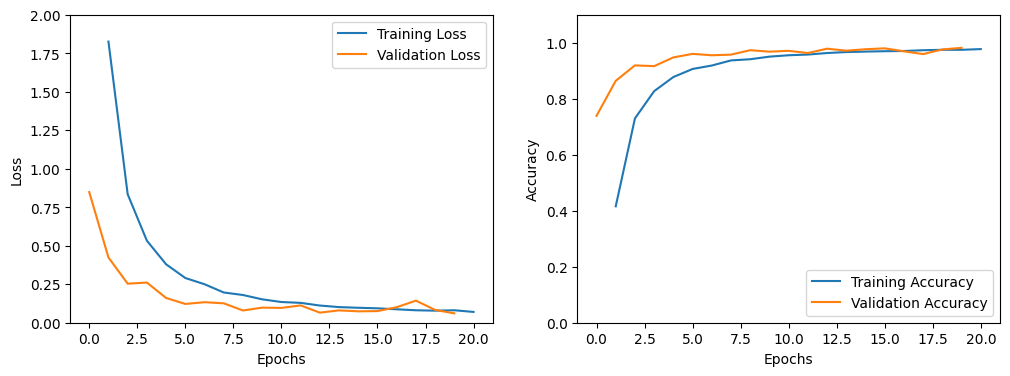

In [24]:
import pandas as pd
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

In [25]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [26]:
best_checkpoint_path = "checkpoints/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 19) - Validation Loss: 0.061, Validation Accuracy: 0.982


In [27]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.977
Test Time: 18.03 seconds ---> 0.30 minutes


In [28]:
total_class = 20
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       271
           1       0.99      0.98      0.98       248
           2       0.98      1.00      0.99        64
           3       1.00      1.00      1.00        62
           4       1.00      0.93      0.96        84
           5       0.99      0.99      0.99       154
           6       0.97      0.99      0.98       137
           7       0.97      0.98      0.97       265
           8       0.99      0.98      0.99       126
           9       1.00      1.00      1.00        86
          10       1.00      0.98      0.99       272
          11       0.99      0.97      0.98       265
          12       0.98      1.00      0.99       140
          13       0.99      0.99      0.99       234
          14       0.99      0.98      0.98       375
          15       0.93      0.99      0.96       213
          16       0.96      0.96      0.96       334
    

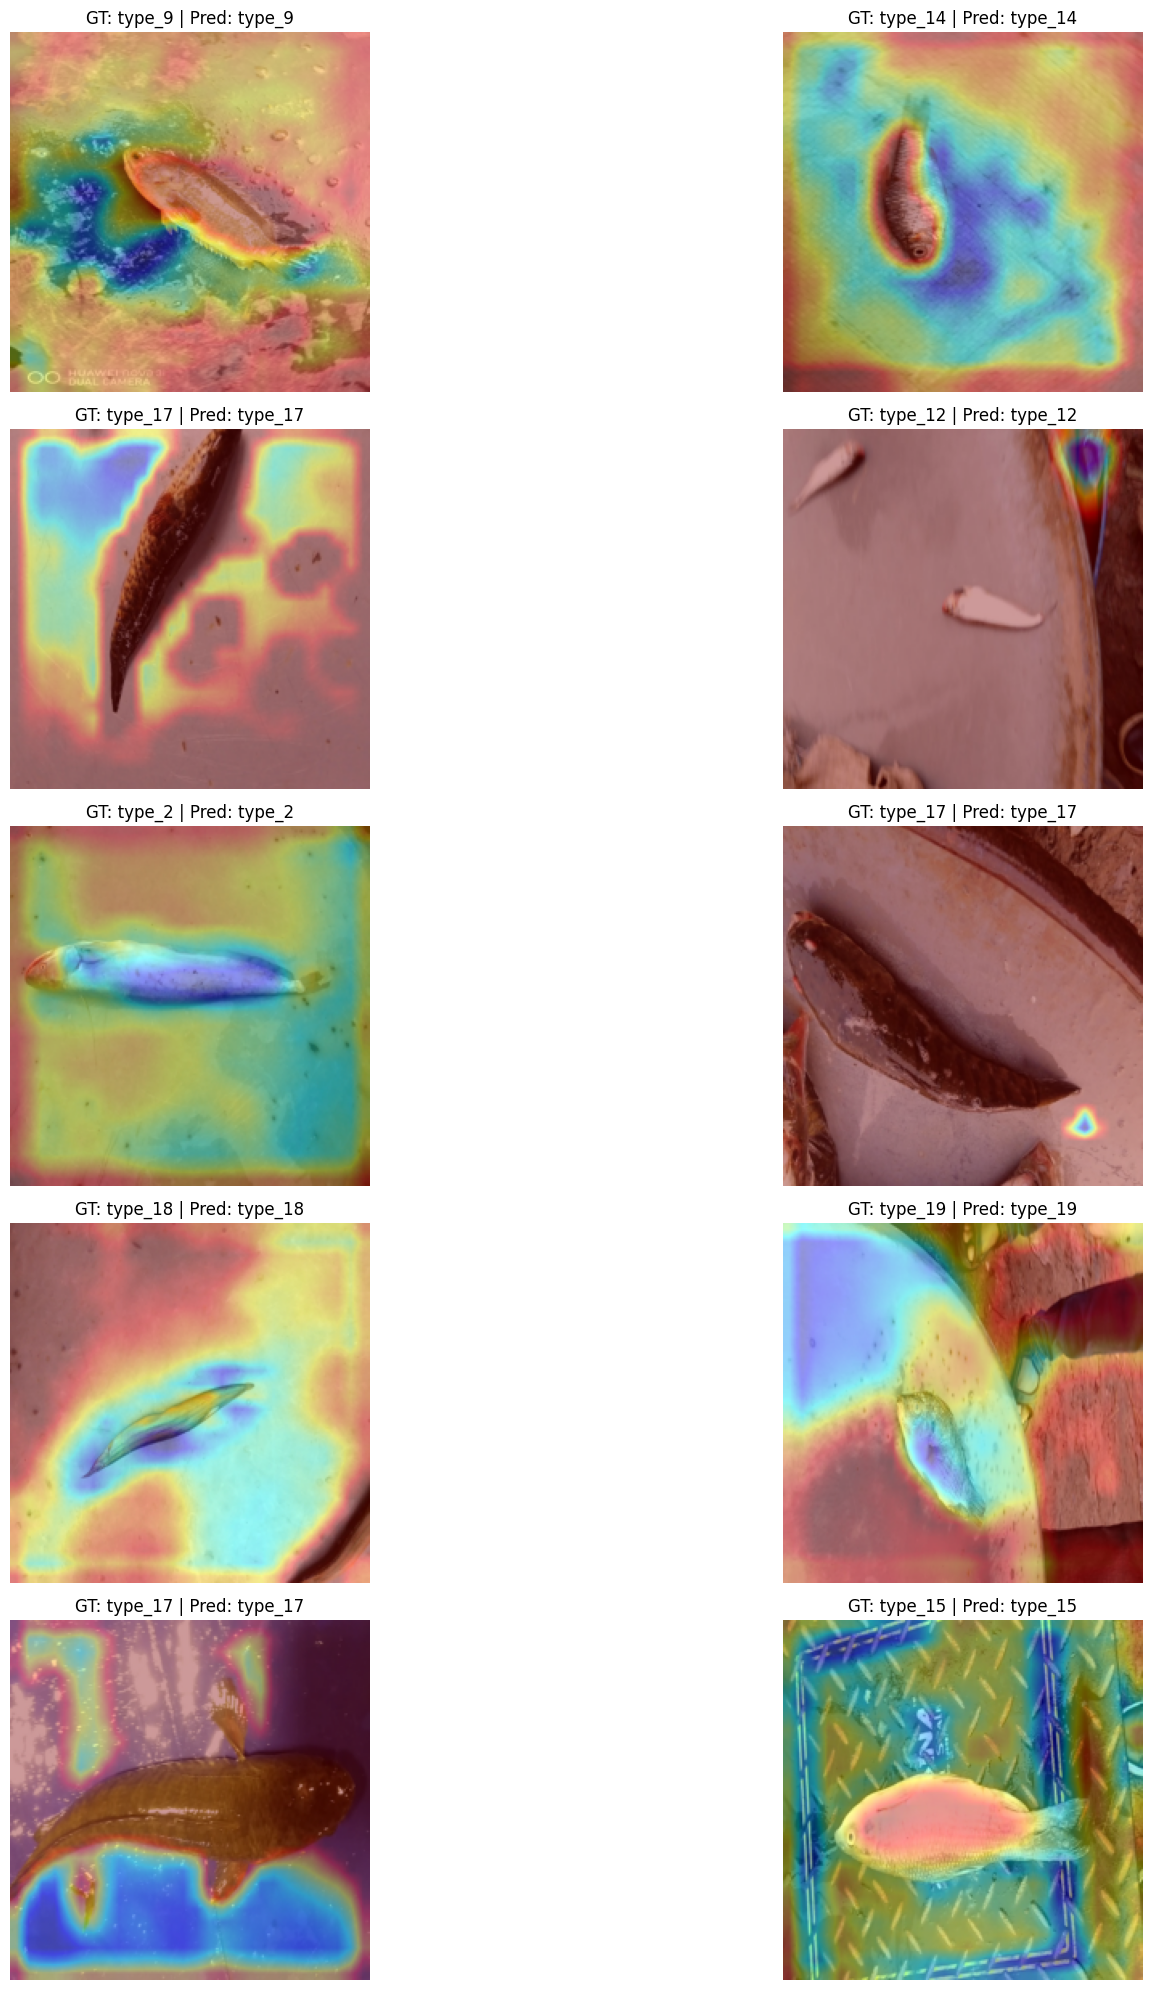

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Use full backward hook for newer PyTorch versions
        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_full_backward_hook(backward_hook)

        self.hook_handles.append(forward_handle)
        self.hook_handles.append(backward_handle)

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()
        class_score = output[:, target_class]
        class_score.backward()

        gradients = self.gradients  # shape: [B, C, H, W]
        activations = self.activations  # shape: [B, C, H, W]
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)
        cam = F.relu(cam)

        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-6)
        return cam

def show_gradcam(model, dataloader, device, target_layer, classes, num_samples=10):
    gradcam = GradCAM(model, target_layer)

    count = 0
    plt.figure(figsize=(20, 20))

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        for i in range(inputs.size(0)):
            input_tensor = inputs[i].unsqueeze(0)
            label = labels[i].item()

            output = model(input_tensor)
            pred_class = output.argmax(dim=1).item()

            cam = gradcam.generate_cam(input_tensor, pred_class)

            # Reverse normalization (if used): optional based on your transforms
            img_np = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
            img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np))
            img_np = np.uint8(255 * img_np)

            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(heatmap, 0.4, img_np, 0.6, 0)

            plt.subplot(5, 2, count + 1)
            plt.imshow(overlay)
            plt.title(f"GT: {classes[label]} | Pred: {classes[pred_class]}")
            plt.axis('off')

            count += 1
            if count == num_samples:
                plt.tight_layout()
                plt.show()
                gradcam.remove_hooks()
                return

# Assuming your model has 20 classes (as you've stated previously)
class_names = [f"type_{i}" for i in range(1, 21)]

# For your FishNet
target_layer = model.features[12]  # Last conv layer before classifier

# Call Grad-CAM visualization
show_gradcam(model, dataloader_test_dataset, device, target_layer, class_names, num_samples=10)
